**Imports and Setup**

In [1]:
# Import Modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pickle
import string
import re

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

**2. Load and Clean Data**

In [2]:
!unzip "/content/Spam-SMS.zip"

Archive:  /content/Spam-SMS.zip
  inflating: Spam-SMS/Spam SMS       


In [3]:
# Load data
data = pd.read_csv("/content/Spam-SMS/Spam SMS", sep = "\t", header = None)
data.rename(columns= {0: 'Category', 1:'SMS Text'}, inplace = True)
data

,Category,SMS Text
0,ham,WHO ARE YOU SEEING?
1,ham,Great! I hope you like your man well endowed. ...
2,ham,No calls..messages..missed calls
3,ham,Didn't you get hep b immunisation in nigeria.
4,ham,"Fair enough, anything going on?"
...,...,...
7567,spam,LUXURY REDEFINED BY ABW!LIFESTYLE Apartment in...
7568,spam,Luxury expandable Villas by Supertech in GNoid...
7569,spam,LUXURY COTTAGES & VILLAS at Jim Corbett JUNGLE...
7570,spam,Luxurious 2/3BHK apartments in BANNERGHATTA RO...


In [4]:
# Checking Null values
data.isnull().sum()

,0
Category,0
SMS Text,0


In [5]:
# Checking duplicate values
data.duplicated().sum()

404

In [6]:
# Remove duplicate values
data = data.drop_duplicates(keep='first')
data

,Category,SMS Text
0,ham,WHO ARE YOU SEEING?
1,ham,Great! I hope you like your man well endowed. ...
2,ham,No calls..messages..missed calls
3,ham,Didn't you get hep b immunisation in nigeria.
4,ham,"Fair enough, anything going on?"
...,...,...
7567,spam,LUXURY REDEFINED BY ABW!LIFESTYLE Apartment in...
7568,spam,Luxury expandable Villas by Supertech in GNoid...
7569,spam,LUXURY COTTAGES & VILLAS at Jim Corbett JUNGLE...
7570,spam,Luxurious 2/3BHK apartments in BANNERGHATTA RO...


In [7]:
# After removing duplicate values
data.duplicated().sum()

0

In [8]:
# Reset index
data = data.reset_index(drop=True)
data

,Category,SMS Text
0,ham,WHO ARE YOU SEEING?
1,ham,Great! I hope you like your man well endowed. ...
2,ham,No calls..messages..missed calls
3,ham,Didn't you get hep b immunisation in nigeria.
4,ham,"Fair enough, anything going on?"
...,...,...
7163,spam,LUXURY REDEFINED BY ABW!LIFESTYLE Apartment in...
7164,spam,Luxury expandable Villas by Supertech in GNoid...
7165,spam,LUXURY COTTAGES & VILLAS at Jim Corbett JUNGLE...
7166,spam,Luxurious 2/3BHK apartments in BANNERGHATTA RO...


In [9]:
# Checking basic data infermation
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7168 entries, 0 to 7167
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  7168 non-null   object
 1   SMS Text  7168 non-null   object
dtypes: object(2)
memory usage: 112.1+ KB


**2. Exploratory Data Analysis (EDA)**

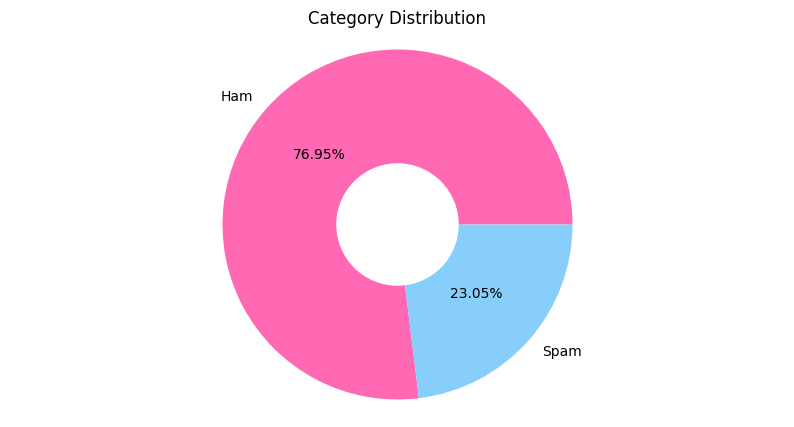

In [10]:
# Plot category distribution
plt.figure(figsize=(10,5))
plt.pie(x=data['Category'].value_counts(), labels = ('Ham','Spam'),
       autopct = '%.2f%%', colors = ["hotpink","lightskyblue"])

# Add a white circle in the center for aesthetics
circle = plt.Circle((0, 0), 0.35, fc='white')
plt.gca().add_artist(circle) # get current axes
plt.title('Category Distribution')
plt.axis('equal');

In [11]:
# Print category percentage
print(f"SMS Not Spam : {round(data['Category'].value_counts()[0] / len(data) * 100, 2)} %")
print(f"SMS Spam : {round(data['Category'].value_counts()[1] / len(data) * 100, 2)} %")

SMS Not Spam : 76.95 %
SMS Spam : 23.05 %


<ipython-input-11-57cc5a6843c0>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"SMS Not Spam : {round(data['Category'].value_counts()[0] / len(data) * 100, 2)} %")
<ipython-input-11-57cc5a6843c0>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"SMS Spam : {round(data['Category'].value_counts()[1] / len(data) * 100, 2)} %")


In [12]:
data['num_characters'] = data['SMS Text'].apply(len)
data.head()

,Category,SMS Text,num_characters
0,ham,WHO ARE YOU SEEING?,19
1,ham,Great! I hope you like your man well endowed. ...,72
2,ham,No calls..messages..missed calls,32
3,ham,Didn't you get hep b immunisation in nigeria.,45
4,ham,"Fair enough, anything going on?",31


In [13]:
data['num_words'] = data['SMS Text'].apply(lambda x : len(nltk.word_tokenize(x)))
data.head()

,Category,SMS Text,num_characters,num_words
0,ham,WHO ARE YOU SEEING?,19,5
1,ham,Great! I hope you like your man well endowed. ...,72,22
2,ham,No calls..messages..missed calls,32,7
3,ham,Didn't you get hep b immunisation in nigeria.,45,10
4,ham,"Fair enough, anything going on?",31,7


In [14]:
data['num_sent'] = data['SMS Text'].apply(lambda y : len(nltk.sent_tokenize(y)))
data.head()

,Category,SMS Text,num_characters,num_words,num_sent
0,ham,WHO ARE YOU SEEING?,19,5,1
1,ham,Great! I hope you like your man well endowed. ...,72,22,3
2,ham,No calls..messages..missed calls,32,7,1
3,ham,Didn't you get hep b immunisation in nigeria.,45,10,1
4,ham,"Fair enough, anything going on?",31,7,1


In [15]:
data.describe()

,num_characters,num_words,num_sent
count,7168.000000,7168.000000,7168.000000
mean,97.476004,21.831752,2.137556
std,81.734073,18.127823,1.852988
min,2.000000,1.000000,1.000000
25%,40.000000,10.000000,1.000000
50%,81.000000,19.000000,2.000000
75%,147.000000,29.000000,3.000000
max,2007.000000,458.000000,38.000000


In [16]:
data[data['Category'] == 'ham'].describe()

,num_characters,num_words,num_sent
count,5516.000000,5516.000000,5516.000000
mean,82.529369,19.886331,2.005257
std,85.080053,19.691730,1.957983
min,2.000000,1.000000,1.000000
25%,35.000000,9.000000,1.000000
50%,58.000000,14.000000,1.000000
75%,112.000000,26.000000,2.000000
max,2007.000000,458.000000,38.000000


In [17]:
data[data['Category'] == 'spam'].describe()

,num_characters,num_words,num_sent
count,1652.000000,1652.000000,1652.000000
mean,147.382567,28.327482,2.579298
std,39.767801,8.739581,1.358423
min,11.000000,1.000000,1.000000
25%,136.000000,24.000000,1.000000
50%,152.000000,28.000000,2.000000
75%,159.000000,32.000000,3.000000
max,509.000000,99.000000,9.000000


**3. Text Preprocessing**



*   Lower Cases
*   Tokenization
*   Removing Special Character
*   Removing Stop Words and Punctuation
*   Stemming



In [18]:
# Simplifies words to their root forms to reduce complexity and improve text processing efficiency.
port_stemmer = PorterStemmer()

# Reducing word variants for consistency in analysis.
lan_stemmer = LancasterStemmer()

# Converts words to their base forms (lemmas) using context and part of speech for more accurate and meaningful text analysis.
lemmatizer = WordNetLemmatizer()

In [19]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [20]:
# Converts words to their base forms (lemmas) using context and part of speech for more accurate and meaningful text analysis.
lemmatizer = WordNetLemmatizer()

**3. Define Text Cleaning Function**

In [21]:
# Create a function to generate cleaned data from raw text
def clean_text(text):

  # Tokenize the text
  texts = word_tokenize(text)

  # Remove punctuation
  texts = [word for word in texts if word not in string.punctuation]

  # Remove numbers
  texts = [word for word in texts if not re.search(r'\d', word)]

  # Convert to lowercase and remove stopwords
  stop_words = set(stopwords.words('english'))
  texts = [word.lower() for word in texts if word.lower() not in stop_words]

  # Apply stemming
  texts = [lemmatizer.lemmatize(word) for word in texts]

  # join text back into a single string
  return " ".join(texts)

# Apply clean function
data['Clean SMS'] = data['SMS Text'].apply(clean_text)

In [22]:
# Example
#example_text = "Here's an example text with numbers 123 and punctuation! Does it clean properly?"
#cleaned_text = clean_text(example_text)
#print(cleaned_text)

In [23]:
data.columns

Index(['Category', 'SMS Text', 'num_characters', 'num_words', 'num_sent',
       'Clean SMS'],
      dtype='object')

In [24]:
data.head(10)

,Category,SMS Text,num_characters,num_words,num_sent,Clean SMS
0,ham,WHO ARE YOU SEEING?,19,5,1,seeing
1,ham,Great! I hope you like your man well endowed. ...,72,22,3,great hope like man well endowed lt gt inch ...
2,ham,No calls..messages..missed calls,32,7,1,call .. message .. missed call
3,ham,Didn't you get hep b immunisation in nigeria.,45,10,1,n't get hep b immunisation nigeria
4,ham,"Fair enough, anything going on?",31,7,1,fair enough anything going
5,ham,"Yeah hopefully, if tyler can't do it I could m...",67,16,1,yeah hopefully tyler ca n't could maybe ask ar...
6,ham,U don't know how stubborn I am. I didn't even ...,148,37,4,u n't know stubborn n't even want go hospital ...
7,ham,What you thinked about me. First time you saw ...,58,14,2,thinked first time saw class
8,ham,"A gram usually runs like &lt;#&gt; , a half e...",124,35,1,gram usually run like lt gt half eighth smarte...
9,ham,K fyi x has a ride early tomorrow morning but ...,80,17,1,k fyi x ride early tomorrow morning 's crashin...


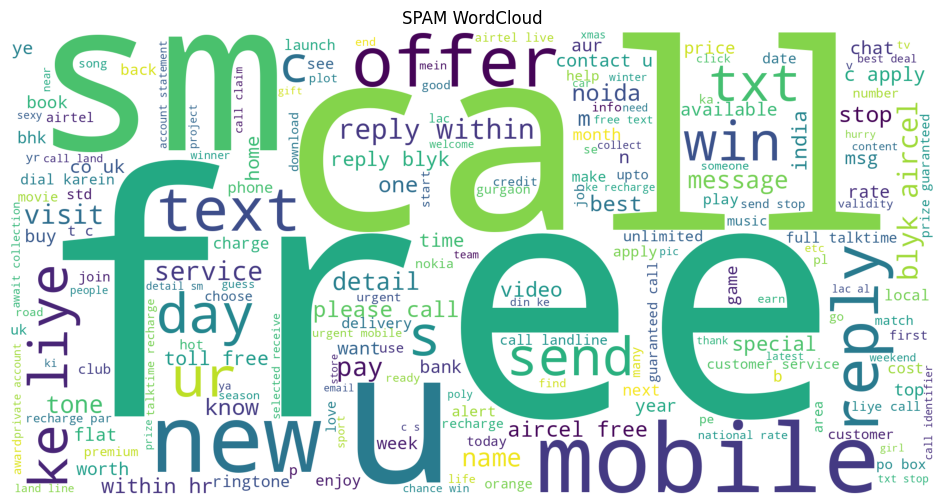

In [25]:
from wordcloud import WordCloud
wc = WordCloud(width = 2000, height = 1000, min_font_size = 10, background_color = 'White')

spam_ = wc.generate(data[data['Category']=='spam']['Clean SMS'].str.cat(sep = " "));
plt.figure(figsize = (15,6))
plt.axis('off')
plt.title('SPAM WordCloud')
plt.imshow(spam_);

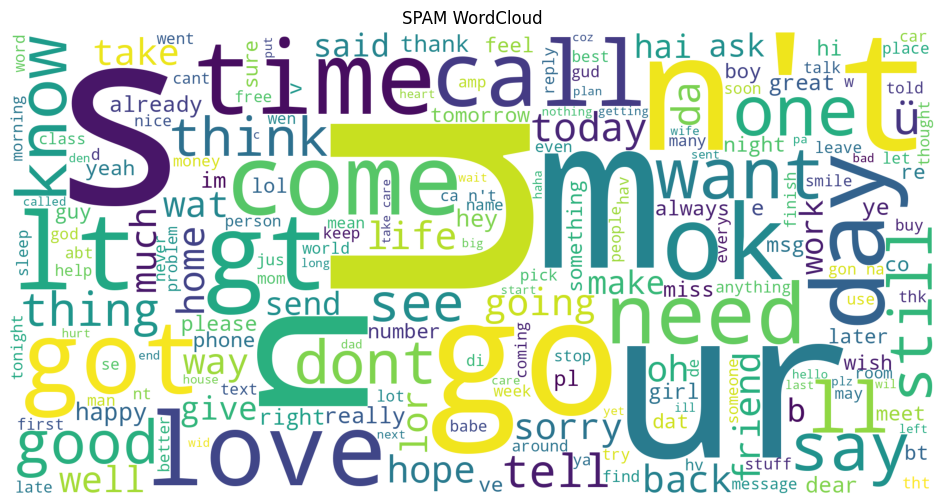

In [26]:
wc = WordCloud(width = 2000, height = 1000, min_font_size = 10, background_color = 'White')

ham_ = wc.generate(data[data['Category']=='ham']['Clean SMS'].str.cat(sep = " "));
plt.figure(figsize = (15,6))
plt.axis('off')
plt.title('SPAM WordCloud')
plt.imshow(ham_);

In [27]:
# Create a function to generate cleaned data from raw text by using port stemmer
def clean_text(text):

  # Tokenize the text
  texts = word_tokenize(text)

  # Remove punctuation
  texts = [word for word in texts if word not in string.punctuation]

  # Remove numbers
  texts = [word for word in texts if not re.search(r'\d', word)]

  # Convert to lowercase and remove stopwords
  stop_words = set(stopwords.words('english'))
  texts = [word.lower() for word in texts if word.lower() not in stop_words]

  # Apply stemming
  texts = [port_stemmer.stem(word) for word in texts]

  # join text back into a single string
  return " ".join(texts)

# Apply clean function
data['Clean SMS'] = data['SMS Text'].apply(clean_text)

In [28]:
data['Clean SMS']

,Clean SMS
0,see
1,great hope like man well endow lt gt inch ...
2,call .. messag .. miss call
3,n't get hep b immunis nigeria
4,fair enough anyth go
...,...
7163,luxuri redefin abw lifestyl apart influenc dre...
7164,luxuri expand villa supertech gnoida floor fur...
7165,luxuri cottag villa jim corbett jungl nainit s...
7166,luxuri apart bannerghatta road close meenakshi...


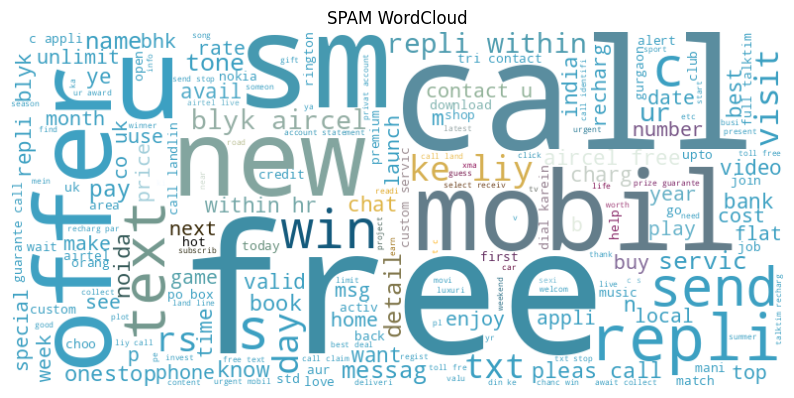

In [29]:
from wordcloud import WordCloud, ImageColorGenerator
import numpy as np
from PIL import Image

mask = np.array(Image.open("/content/spamimage.jpg"))  # Replace "spam_can.png" with your image file

#Grab the mask colors
colors = ImageColorGenerator(mask)

#Instantiate the wordcloud using color_func argument
cloud = WordCloud(mask=mask,
                  background_color='White',
                  color_func=colors)

# Filter and concatenate text data for spam emails into a single string
spam_data = data[data['Category'] == 'spam']
if len(spam_data) > 0:
    spam_text = spam_data['Clean SMS'].str.cat(sep=" ")
else:
    raise ValueError("No spam sms found in the data.")

# Generate the WordCloud from the concatenated text
if spam_text.strip():  # Check if spam_text is not empty or contains only whitespace
    cloud.generate_from_text(spam_text)
else:
    raise ValueError("No text found spam SMS.")


#Plot the wordcloud
plt.figure(figsize=(10,8))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.title('SPAM WordCloud')
plt.show()

array([[[ 60, 160, 194],
        [ 60, 160, 194],
        [ 60, 160, 194],
        ...,
        [ 60, 160, 194],
        [ 60, 160, 194],
        [ 60, 160, 194]],

       [[ 60, 160, 194],
        [ 60, 160, 194],
        [ 60, 160, 194],
        ...,
        [ 60, 160, 194],
        [ 60, 160, 194],
        [ 60, 160, 194]],

       [[ 60, 160, 194],
        [ 60, 160, 194],
        [ 60, 160, 194],
        ...,
        [ 60, 160, 194],
        [ 60, 160, 194],
        [ 60, 160, 194]],

       ...,

       [[ 60, 160, 194],
        [ 60, 160, 194],
        [ 60, 160, 194],
        ...,
        [ 60, 160, 194],
        [ 60, 160, 194],
        [ 60, 160, 194]],

       [[ 60, 160, 194],
        [ 60, 160, 194],
        [ 60, 160, 194],
        ...,
        [ 60, 160, 194],
        [ 60, 160, 194],
        [ 60, 160, 194]],

       [[ 60, 160, 194],
        [ 60, 160, 194],
        [ 60, 160, 194],
        ...,
        [ 60, 160, 194],
        [ 60, 160, 194],
        [ 60, 160, 194]]], dtype=uint8)
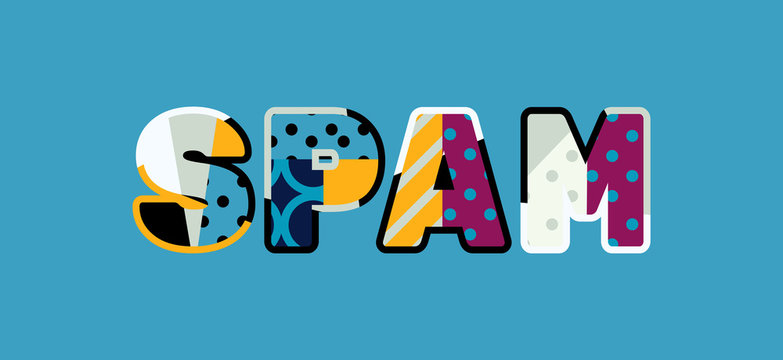

In [30]:
mask

**4. Model Building**


1.   Feature Extraction


In [31]:
# Vectorize the cleaned text

# Initialize the TF-IDF vectorizer
tf_idf = TfidfVectorizer(max_features=2700)

# Fit and Transform the text column
X = tf_idf.fit_transform(data['Clean SMS']).toarray()
y = data['Category'].map({'ham': 0, 'spam': 1}).values

# Save the vecctorizer
pickle.dump(tf_idf, open('vectorizer.pkl', 'wb'))

In [32]:
#from sklearn.preprocessing import LabelEncoder

# Intialize the LabelEncoder
#encoder = LabelEncoder()

# Fit and Transform the labels
#data['target'] = encoder.fit_transform(data['Category'])

In [33]:
#from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#cv = CountVectorizer()

In [34]:
#y = data['target'].values

In [35]:
y

array([0, 0, 0, ..., 1, 1, 1])



2.   Model Training and Evaluation



In [36]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 42)

# Define Models
models = {
    'GNB': GaussianNB(),
    'MNB': MultinomialNB(),
    'BNB': BernoulliNB()
}

# Train and evalute models
for model_name, model in models.items():
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  print(f"{model_name} - Accuracy: {accuracy_score(y_test, y_pred):.4f}, Precision: {precision_score(y_test, y_pred):.4f}, Recall: {recall_score(y_test, y_pred):.4f}, F1 Score: {f1_score(y_test, y_pred):.4f}")
  print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n")

GNB - Accuracy: 0.7601, Precision: 0.4992, Recall: 0.9009, F1 Score: 0.6424
Confusion Matrix:
[[781 310]
 [ 34 309]]

MNB - Accuracy: 0.9651, Precision: 0.9681, Recall: 0.8834, F1 Score: 0.9238
Confusion Matrix:
[[1081   10]
 [  40  303]]

BNB - Accuracy: 0.9714, Precision: 0.9632, Recall: 0.9155, F1 Score: 0.9387
Confusion Matrix:
[[1079   12]
 [  29  314]]



In [37]:
# Save the best model
best_model = models['BNB']
pickle.dump(best_model, open('model.pkl', 'wb'))

**5. Prediction Function**

In [38]:
def predict_spam(sms):

  # Load necessary objects
  tf_idf = pickle.load(open('vectorizer.pkl', 'rb'))
  model = pickle.load(open('model.pkl', 'rb'))

  # Clean and vectorize the input SMS
  transformed_sms = clean_text(sms)
  vect_input = tf_idf.transform([transformed_sms])

  # Predict and display result
  result = model.predict(vect_input)[0]
  return 'Spam' if result == 1 else 'Not Spam'


In [39]:
# Example usage
sms = "Dear Customer, FREE Lens Upgrade - claim now or forever live in FOMO, cause Lenskart's Eye-conic Sale ends in 2 days! TnC App lskt.me/lb Store lskt.me/m8"
print(predict_spam(sms))

Spam


In [40]:
# Example usage
sms = "Hey, are we still meeting for lunch at 12:30?"
print(predict_spam(sms))

Not Spam
